In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
X_train = np.load('/kaggle/input/motorica-skillfactory-internship-test-2024-07/X_train.npy')
X_test = np.load('/kaggle/input/motorica-skillfactory-internship-test-2024-07/X_test.npy')

y_train = pd.read_csv('/kaggle/input/motorica-skillfactory-internship-test-2024-07/y_train.csv')
y_test = pd.read_csv('/kaggle/input/motorica-skillfactory-internship-test-2024-07/sample_submission.csv')
# y_test = pd.read_csv('./sample_submission.csv')

print(X_train.shape, y_train.shape)
print(X_test.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/motorica-skillfactory-internship-test-2024-07/X_train.npy'

In [23]:
import numpy as np
import pandas as pd
#%matplotlib widget
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка

from sklearn.metrics import classification_report

import warnings # для игнорирования предупреждений
#Игнорируем варнинги
warnings.filterwarnings('ignore')

In [24]:
#X_train = np.load('data/X_train.npy')
#X_test = np.load('data/X_test.npy')

#y_train = pd.read_csv('data/y_train.csv')
#y_test = pd.read_csv('data/sample_submission.csv')
# y_test = pd.read_csv('./sample_submission.csv')

#print(X_train.shape, y_train.shape)
#print(X_test.shape)

(323, 40, 100) (32300, 2)
(54, 40, 100)


## Представление целевой переменной
### Kaggle-удобный вид

In [25]:
print(y_train.shape)
y_train

(32300, 2)


,sample-timestep,class
0,0-0,0
1,0-1,0
2,0-2,0
3,0-3,0
4,0-4,0
...,...,...
32295,322-95,4
32296,322-96,4
32297,322-97,4
32298,322-98,4


<Axes: xlabel='class', ylabel='count'>

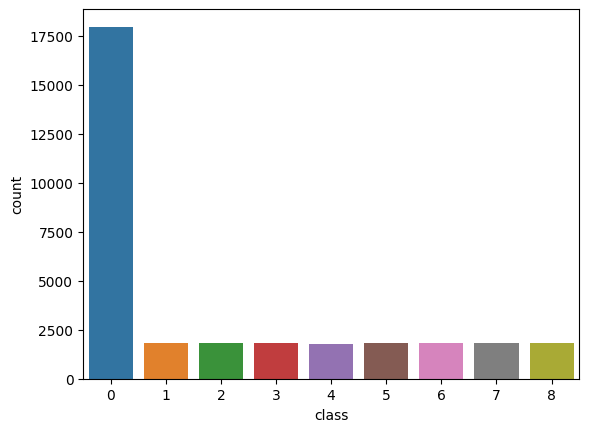

In [26]:
sns.countplot(data=y_train, x='class') #смотрим на сбалансированность классов

### Исходный вид

In [27]:
y_train[['sample_id', 'timestep']] = y_train['sample-timestep'].str.split('-', expand=True).astype(int)
y_train = y_train.pivot(index='sample_id', columns='timestep', values='class')
y_train_index = y_train.index
y_train = y_train.sort_index() # на всякий случай
y_train = y_train.values

print(y_train.shape)
y_train

(323, 100)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 6, 6, 6],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]], dtype=int64)

In [28]:
#приведем массивы в двухмерный вид для построения модели
X_train = X_train.reshape(32300,40)
y_train = y_train.reshape(32300,1)
X_test = X_test.reshape(5400,40)

<Axes: >

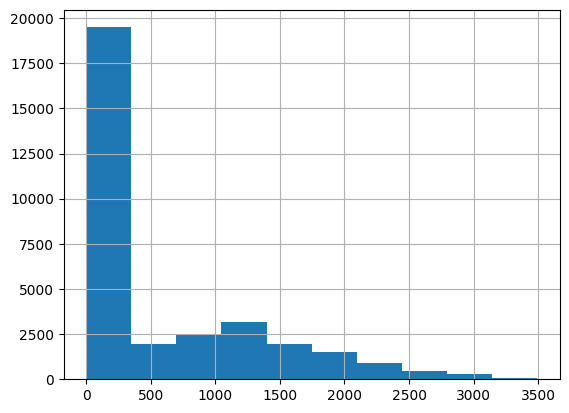

In [29]:
#посмотрим на распределение признаков
X_train_df = pd.DataFrame(X_train)
X_train_df

X_train_df[0].hist()

In [30]:
#нормализуем данные
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train= scaler.transform(X_train)

scaler.fit(X_test)
X_test= scaler.transform(X_test)

In [31]:
import optuna #будем оптимизировать гиперпараметры модели с помощью Optuna

print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.6.1


In [32]:

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 40, 60, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42
                                          )
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train),average='macro')

  return score

In [33]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-08-06 20:04:54,562] A new study created in memory with name: RandomForestClassifier
[I 2024-08-06 20:06:00,926] Trial 0 finished with value: 0.37298610873992977 and parameters: {'n_estimators': 185, 'max_depth': 46, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.37298610873992977.
[I 2024-08-06 20:06:36,410] Trial 1 finished with value: 0.20984495616796497 and parameters: {'n_estimators': 112, 'max_depth': 44, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.37298610873992977.
[I 2024-08-06 20:07:12,433] Trial 2 finished with value: 0.1966629062312391 and parameters: {'n_estimators': 117, 'max_depth': 44, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.37298610873992977.
[I 2024-08-06 20:07:56,733] Trial 3 finished with value: 0.2118076272428867 and parameters: {'n_estimators': 140, 'max_depth': 56, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.37298610873992977.
[I 2024-08-06 20:10:15,036] Trial 4 finished with value: 0.2573727038226785 and parameter

KeyboardInterrupt: 

In [34]:
# выводим наилучшие результаты гиперпараметров
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

Наилучшие значения гиперпараметров {'n_estimators': 161, 'max_depth': 60, 'min_samples_leaf': 2}


In [35]:
#обучаем модель на выбранных параметрах
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [36]:
#выведем таблицу значений метрик
print(metrics.classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     17950
           1       1.00      0.94      0.97      1800
           2       1.00      0.94      0.97      1800
           3       1.00      0.94      0.97      1800
           4       1.00      0.95      0.97      1750
           5       1.00      0.94      0.97      1800
           6       1.00      0.91      0.95      1800
           7       1.00      0.95      0.97      1800
           8       1.00      0.96      0.98      1800

    accuracy                           0.97     32300
   macro avg       0.99      0.95      0.97     32300
weighted avg       0.97      0.97      0.97     32300



In [37]:
y_test_pred.shape

(5400,)

In [38]:
y_test['class'] = y_test_pred
y_test

,sample-timestep,class
0,323-0,0
1,323-1,0
2,323-2,0
3,323-3,0
4,323-4,0
...,...,...
5395,376-95,0
5396,376-96,0
5397,376-97,0
5398,376-98,0


In [40]:
y_test.to_csv('./submission.csv', index=False)
y_test

,sample-timestep,class
0,323-0,0
1,323-1,0
2,323-2,0
3,323-3,0
4,323-4,0
...,...,...
5395,376-95,0
5396,376-96,0
5397,376-97,0
5398,376-98,0
